<a href="https://colab.research.google.com/github/nicholassung97/DemonstrationofPINNs/blob/main/1D_Kinematics_with_physics_equation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***1D Kinematics Equation using PINNs***


---


#Setting Up Libraries

Install the pyDOE library

In [ ]:
!pip install --upgrade pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=5c11456b4d25e5468e58c953c4c090a996f1fcf96dbe3196fc8862e9997256e4
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


Import the other flow libraries 
(Convert tensorflow to version 1)

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

TensorFlow 1.x selected.


Random Seed

In [ ]:
np.random.seed(1234)
tf.set_random_seed(1234) # New version of tensorflow uses random.set_seed instead

Install Latex Package

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  f

#Setting Up PhysicsInformedNN


In [ ]:
class PhysicsInformedNN:
    # Initialize the class
      def __init__(self, t_b, x_b, t_f, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        # Boundary conditions of x(t=0)=0 and x(t=10)=0
        # Time boundary conditions
        self.t_b = t_b
        # Displacement boundary conditions
        self.x_b = x_b
        # Function time conditions
        self.t_f = t_f
        # Neurons in each layer
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.t_b_tf = tf.placeholder(tf.float32, shape=[None, self.t_b.shape[1]])        
        self.x_b_tf = tf.placeholder(tf.float32, shape=[None, self.x_b.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        self.x_b_pred = self.net_x_b(self.t_b_tf) 
        self.f_pred = self.net_f(self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.x_b_tf - self.x_b_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

Function to create weights and biases based on layers

In [ ]:
    def initialize_NN(self, layers):          # Creates weights and biases   
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            # creates rows of zeros (len of layers)
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    PhysicsInformedNN.initialize_NN = initialize_NN

Function to generate range of values based on the normal distribution

In [ ]:
    def xavier_init(self, size):            # Generates values with following a normal distribution 
        in_dim = size[0]
        out_dim = size[1] 
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        # Initializer that generates a truncated normal distribution.
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    PhysicsInformedNN.xavier_init = xavier_init

Function that run through the neural network

In [ ]:
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y 
    PhysicsInformedNN.neural_net = neural_net

Function that returns x when t is entered

In [ ]:
    def net_x_b(self, t):
        x = self.neural_net(tf.concat([t],1), self.weights, self.biases)
        return x
    PhysicsInformedNN.net_x_b = net_x_b

Function that returns cost function when t is entered

In [ ]:
    def net_f(self, t):
        x = self.net_x_b(t)
        x_t = tf.gradients(x, t)[0]
        x_tt = tf.gradients(x_t, t)[0]
        f = x_tt + 10        
        return f
    PhysicsInformedNN.net_f = net_f

Function that prints the loss 

In [ ]:
    def callback(self, loss):
        print('Loss:', loss)
    PhysicsInformedNN.callback = callback

Function that outputs iterations, loss and time given no of iterations

In [ ]:
    def train(self):
        
        tf_dict = {self.t_b_tf: self.t_b, self.x_b_tf: self.x_b, self.t_f_tf: self.t_f}
                                                                                                                         
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)  
    PhysicsInformedNN.train = train

Functions that produces the predicted values for x and f

In [ ]:
    def predict(self, t_star):
                
        x_star = self.sess.run(self.x_b_pred, {self.t_b_tf: t_star[:,0:1]})  
        f_star = self.sess.run(self.f_pred, {self.t_f_tf: t_star[:,0:1]})
               
        return x_star, f_star
    PhysicsInformedNN.predict = predict

# Input Training values into PhysicsInformedNN

Creating Training Values

In [ ]:
# Boundary Condtions (lb: t=0 and ub: t=10 )
lb = 0
ub = 10
# Creates an array of t with intervals of 0.01
t = np.arange(lb, ub, 0.01)
x = -5*t*t + 50*t
t_star = t.flatten()[:,None]
x_star = x.flatten()[:,None]
# Layers for Neural Network
layers =  [1, 20, 1]    
# Boundary Conditions for time and displacement
t_b_train = np.vstack([t_star[0,:], t_star[-1,:]])
x_b_train = np.vstack([x_star[0,:], x_star[-1,:]])
# Collocation time values that will include the extrapolation time range from t=10 to t=15
lb_collocation = 0
ub_collocation = 15
N_f = 100
t_f_train = lb_collocation + (ub_collocation-lb_collocation)*lhs(1, N_f)


#Training the model

In [ ]:
model = PhysicsInformedNN(t_b_train, x_b_train, t_f_train, layers, lb, ub)
start_time = time.time()                
model.train()
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Loss: 100.168816
Loss: 100.78775
Loss: 99.96482
Loss: 99.960144
Loss: 99.946014
Loss: 99.8962
Loss: 99.76619
Loss: 97.779945
Loss: 372.37732
Loss: 97.23211
Loss: 97.01684
Loss: 96.914894
Loss: 210.8931
Loss: 97.13168
Loss: 96.8673
Loss: 95.58588
Loss: 94.51178
Loss: 93.07119
Loss: 92.15242
Loss: 91.58275
Loss: 91.25301
Loss: 91.03763
Loss: 90.62234
Loss: 90.364395
Loss: 90.182465
Loss: 89.98205
Loss: 89.709496
Loss: 88.930046
Loss: 88.05281
Loss: 87.645615
Loss: 87.40696
Loss: 87.12376
Loss: 86.64397
Loss: 86.04815
Loss: 87.13605
Loss: 85

#Interpolation

Predicting Interpolation Values

In [ ]:
# Input 25 percent of the data set as testing data
idx_train = np.random.choice(t_star.shape[0], int(t_star.shape[0]*0.25) , replace=False)
t_test = t_star[idx_train, :]
x_test = x_star[idx_train, :]
x_pred, f_pred = model.predict(t_test)

Plotting for Interpolation

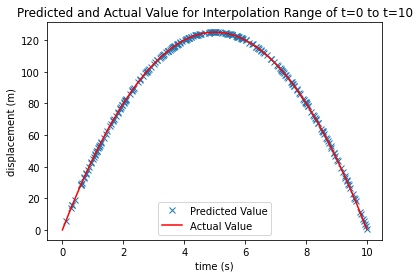

In [ ]:
from matplotlib import pyplot as plt
plt.title('Predicted and Actual Value for Interpolation Range of t=0 to t=10')
plt.plot(t_test, x_pred, 'x', label='Predicted Value')
plt.plot(t_star, x_star, 'r-', label='Actual Value')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.show()

# Extrapolation

Predicting Exrapolation Values

In [ ]:
lb_extrap = 10
ub_extrap = 15
t1 = np.arange(lb_extrap, ub_extrap, 0.1)
x1 = -5*t1*t1 + 50*t1
t_true_extrap = t1.flatten()[:,None]
x_true_extrap = x1.flatten()[:,None]
x_pred_extrap, f_pred = model.predict(t_true_extrap)

Plotting for Extrapolation

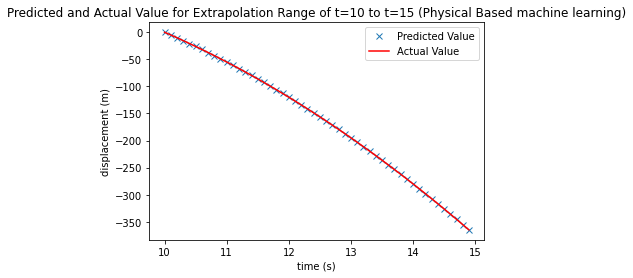

In [ ]:
from matplotlib import pyplot as plt
plt.title('Predicted and Actual Value for Extrapolation Range of t=10 to t=15 (Physical Based machine learning)')
plt.plot(t_true_extrap, x_pred_extrap, 'x', label='Predicted Value')
plt.plot(t_true_extrap, x_true_extrap, 'r-', label='Actual Value')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.show()